# Quickstart

### Install maenvs4vrp 

Uncomment the following cells:

In [ ]:
#!git clone https://github.com/ricgama/maenvs4vrp.git

In [ ]:
# When using Colab
#%cd maenvs4vrp
#%mv maenvs4vrp/ repo_temp/
#%mv repo_temp/ ..
#%cd ..
#%cp maenvs4vrp/setup.py repo_temp/
#%rm -r maenvs4vrp
#%mv repo_temp/ maenvs4vrp/
#%cd maenvs4vrp/
#!pip install .

Let's begin exploring the **MAEnvs4VRP** library using the **CVRPTW** (Capacitated Vehicle Routing Problem with Time Windows) environment as our working example. The library’s **API design** is inspired by the [**PettingZoo**](https://pettingzoo.farama.org/), which adopts the **Agent Environment Cycle (AEC)** paradigm—where agents act in a defined sequence within a shared environment. Additionally, the library draws influence from the [**Flatland**](https://flatland.aicrowd.com/intro.html) environment, adopting several of its design principlesy.


## Basic usage

In [1]:
from maenvs4vrp.environments.cvrptw.env import Environment
from maenvs4vrp.environments.cvrptw.env_agent_selector import AgentSelector
from maenvs4vrp.environments.cvrptw.observations import Observations
from maenvs4vrp.environments.cvrptw.instances_generator import InstanceGenerator
from maenvs4vrp.environments.cvrptw.env_agent_reward import DenseReward
%load_ext autoreload
%autoreload 2

In [2]:
gen = InstanceGenerator(batch_size = 8)
obs = Observations()
sel = AgentSelector()
rew = DenseReward()

env = Environment(instance_generator_object=gen,  
                  obs_builder_object=obs,
                  agent_selector_object=sel,
                  reward_evaluator=rew,
                  seed=0)

In [3]:
td = env.reset(batch_size = 8, num_agents=4, num_nodes=16)
td

TensorDict(
    fields={
        agent_step: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int32, is_shared=False),
        cur_agent_idx: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        cur_node_idx: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.bool, is_shared=False),
        observations: TensorDict(
            fields={
                action_mask: Tensor(shape=torch.Size([8, 16]), device=cpu, dtype=torch.bool, is_shared=False),
                agent_obs: Tensor(shape=torch.Size([8, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                agents_mask: Tensor(shape=torch.Size([8, 4]), device=cpu, dtype=torch.bool, is_shared=False),
                global_obs: Tensor(shape=torch.Size([8, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                node_dynamic_obs: Tensor(shape=torch.Size([8, 16, 8]), de

In [4]:
while not td["done"].all():  
    td = env.sample_action(td) # this is where we insert our policy
    td = env.step(td)

## Basic usage in more detail

In [5]:
from maenvs4vrp.utils.plotting import (plot_instance_coords, plot_random_batch_instances, plot_env_instance_coords, plot_env_random_batch_instances, plot_solution)
from maenvs4vrp.utils.utils import get_solution

In [6]:
# Import the main Environment class for the CVRPTW (Capacitated Vehicle Routing Problem with Time Windows) environment
from maenvs4vrp.environments.cvrptw.env import Environment
# Import the AgentSelector which handles agent selection logic in the environment
from maenvs4vrp.environments.cvrptw.env_agent_selector import AgentSelector
# Import the Observations class that defines how observations are structured and generated
from maenvs4vrp.environments.cvrptw.observations import Observations
# Import the InstanceGenerator for creating CVRPTW problem instances
from maenvs4vrp.environments.cvrptw.instances_generator import InstanceGenerator
# Import the DenseReward class which provides detailed reward signals during training
from maenvs4vrp.environments.cvrptw.env_agent_reward import DenseReward

In [7]:
gen = InstanceGenerator(batch_size = 8)
obs = Observations()
sel = AgentSelector()
rew = DenseReward()

env = Environment(instance_generator_object=gen,  
                  obs_builder_object=obs,
                  agent_selector_object=sel,
                  reward_evaluator=rew,
                  seed=0)

After instantiating the environment we have to reset it:

In [8]:
td = env.reset(batch_size = 8, num_agents=4, num_nodes=16)
td

TensorDict(
    fields={
        agent_step: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int32, is_shared=False),
        cur_agent_idx: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        cur_node_idx: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.bool, is_shared=False),
        observations: TensorDict(
            fields={
                action_mask: Tensor(shape=torch.Size([8, 16]), device=cpu, dtype=torch.bool, is_shared=False),
                agent_obs: Tensor(shape=torch.Size([8, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                agents_mask: Tensor(shape=torch.Size([8, 4]), device=cpu, dtype=torch.bool, is_shared=False),
                global_obs: Tensor(shape=torch.Size([8, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                node_dynamic_obs: Tensor(shape=torch.Size([8, 16, 8]), de

**Understanding the `TensorDict` Keys**

The `TensorDict` acts like a dictionary of tensors holding all the state, observation, and reward information for a batch of agents in your environment. In this case, the batch size is **8**, meaning it holds data for 8 parallel environments.  

**Top-Level Keys**

| Key | Shape | Description |
|------|--------|-------------|
| `agent_step` | `[8, 1]` | Current step number of each agent in the environment. |
| `cur_agent_idx` | `[8, 1]` | Index of the agent currently taking an action. |
| `cur_node_idx` | `[8, 1]` | Index of the node (location) the agent is currently at. |
| `done` | `[8]` (bool) | Whether each environment/episode is finished (`True` = done). |
| `penalty` | `[8]` (float) | step Penalty. |
| `reward` | `[8]` (float) | step Reward signal. |

---

**Nested `observations` TensorDict**

This contains all the observation-related tensors provided to the agent at each step.

| Key (inside `observations`) | Shape | Description |
|------------------------------|--------|-------------|
| `action_mask` | `[8, 16]` (bool) | Mask of valid/invalid actions for each agent at each step. |
| `agent_obs` | `[8, 6]` (float) | Individual agent’s features/observations. |
| `agents_mask` | `[8, 4]` (bool) | Mask showing which agents are active/available. |
| `global_obs` | `[8, 2]` (float) | Global environment features shared by all agents. |
| `node_dynamic_obs` | `[8, 16, 8]` (float) | Dynamic (changing) features of each node/location. |
| `node_static_obs` | `[8, 16, 7]` (float) | Static (fixed) features of each node/location. |
| `other_agents_obs` | `[8, 4, 8]` (float) | Observations of other agents (relative states, positions, etc.). |



Let's visualize some environments instances:

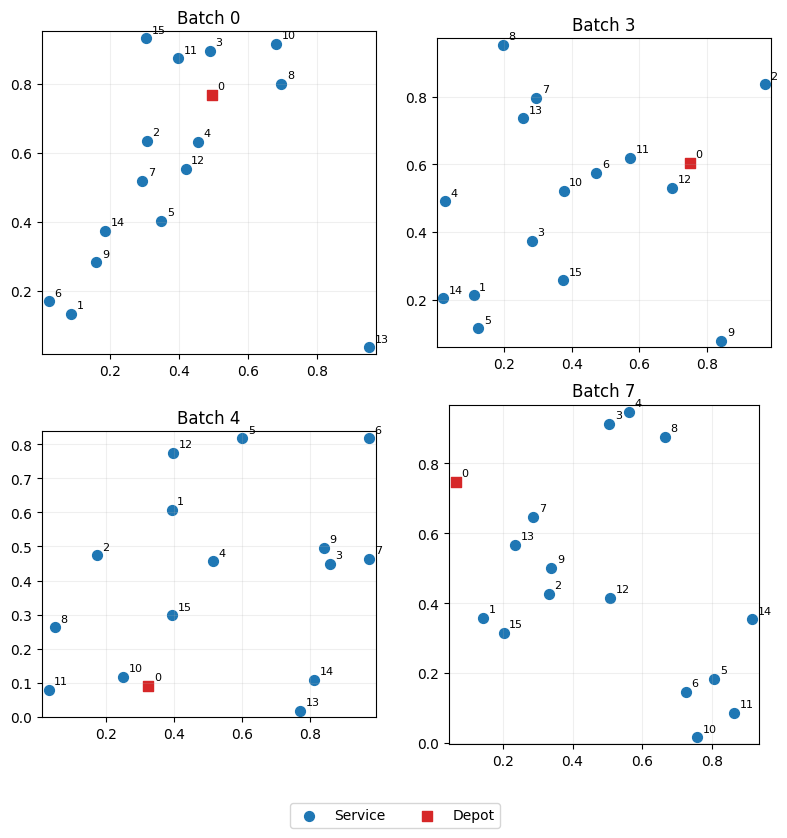

In [9]:
plot_env_random_batch_instances(env, n=4)

and now, perform an episode rollover:

In [10]:
while not td["done"].all():  
    td = env.sample_action(td) # this is where we insert our policy
    td = env.step(td)

and we can visualize the solution:

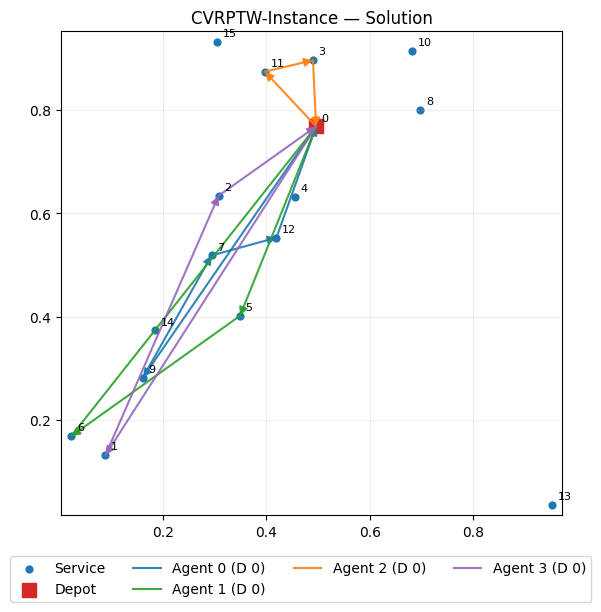

In [37]:
plot_solution(env, batch_idx=0)

## Quick walkthrough

Let's now go through the library's building blocks, exploring their functionalities.

### Instance generation

We can generate instances using one of the two available methods `InstanceGenerator` and `BenchmarkInstanceGenerator`:

In [11]:
from maenvs4vrp.environments.cvrptw.instances_generator import InstanceGenerator
from maenvs4vrp.environments.cvrptw.benchmark_instances_generator import BenchmarkInstanceGenerator

#### Random generated instances

Random instances are generated following:

Li, S., Yan, Z., & Wu, C. (2021). [Learning to delegate for large-scale vehicle routing](https://proceedings.neurips.cc/paper/2021/hash/dc9fa5f217a1e57b8a6adeb065560b38-Abstract.html). Advances in Neural Information Processing Systems, 34, 26198-26211.

In [12]:
generator = InstanceGenerator()

In [13]:
instance = generator.sample_instance(num_agents=2, num_nodes=10)

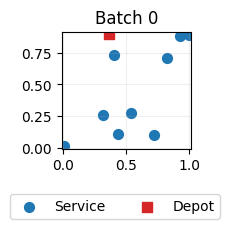

In [15]:
plot_random_batch_instances(instance,
                            n=1,
                            figsize_per_plot=(2,2),
                            annotate=False,
                            )

In [16]:
instance.keys()

dict_keys(['name', 'num_nodes', 'num_agents', 'data'])

In [17]:
instance

{'name': 'random_instance',
 'num_nodes': 10,
 'num_agents': 2,
 'data': TensorDict(
     fields={
         capacity: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
         coords: Tensor(shape=torch.Size([1, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
         demands: Tensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.float32, is_shared=False),
         depot_idx: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
         end_time: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         is_depot: Tensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.bool, is_shared=False),
         service_time: Tensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.float32, is_shared=False),
         start_time: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         tw_high: Tensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.f

**Understanding the VRP Instance**

This object represents a single **vehicle routing problem (VRP) instance**.  
It contains metadata and a `TensorDict` of all the data needed to define the problem.

**Top-Level Metadata**

| Key | Value / Type | Description |
|------|-------------|-------------|
| `name` | `'random_instance'` | Name or identifier of the VRP instance. |
| `num_nodes` | `10` | Total number of nodes (customers + depot). |
| `num_agents` | `2` | Number of agents/vehicles available. |

---

**Nested `data` TensorDict**

This contains all the features of the VRP instance.

| Key (inside `data`) | Shape | Description |
|---------------------|--------|-------------|
| `capacity` | `[1, 1]` (float) | Vehicle capacity constraint. |
| `coords` | `[1, 10, 2]` (float) | Coordinates (x, y) of each node (including depot). |
| `demands` | `[1, 10]` (float) | Demand at each node. |
| `depot_idx` | `[1, 1]` (int) | Index of the depot node. |
| `end_time` | `[1]` (float) | Latest allowed time for route completion. |
| `is_depot` | `[1, 10]` (bool) | Boolean mask indicating which node is the depot. |
| `service_time` | `[1, 10]` (float) | Service time required at each node. |
| `start_time` | `[1]` (float) | Earliest allowed time for route start. |
| `tw_high` | `[1, 10]` (float) | Upper bounds of time windows for each node. |
| `tw_low` | `[1, 10]` (float) | Lower bounds of time windows for each node. |

---

It's possible to load a set of pre-generaded instances, to be used as validation/test sets. For example:

In [18]:
generator.get_list_of_benchmark_instances()

{'servs_100_agents_25': {'validation': ['cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_2',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_31',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_43',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_55',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_0',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_1',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_10',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_11',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_12',
   'cvrptw/data/generated/servs_100_agents_25/validation/generated_val_servs_100_agents_25_13',
   'cv

In [19]:
set_of_instances = set(generator.get_list_of_benchmark_instances()['servs_100_agents_25']['validation'])

In [20]:
generator = InstanceGenerator(instance_type='validation', set_of_instances=set_of_instances)

In [21]:
instance = generator.sample_instance()

Let's check instance dict keys:

In [22]:
instance.keys()

dict_keys(['name', 'num_nodes', 'num_agents', 'data'])

In [23]:
instance['name']

'random_instance'

#### Benchmark instances

In order to narrow the current gap between the test beds for algorithm benchmarking used in RL
and OR communities, the library allows a straightforward integration of classical OR benchmark
instances. For example, we can load a set of classical benchmark instances. Let's see what benchmark instances we have for the CVPTW:

In [24]:
BenchmarkInstanceGenerator.get_list_of_benchmark_instances()

{'Solomon': ['R103',
  'C101',
  'C102',
  'C103',
  'C104',
  'C105',
  'C106',
  'C107',
  'C108',
  'C109',
  'C201',
  'C202',
  'C203',
  'C204',
  'C205',
  'C206',
  'C207',
  'C208',
  'R101',
  'R102',
  'R104',
  'R105',
  'R106',
  'R107',
  'R108',
  'R109',
  'R110',
  'R111',
  'R112',
  'R201',
  'R202',
  'R203',
  'R204',
  'R205',
  'R206',
  'R207',
  'R208',
  'R209',
  'R210',
  'R211',
  'RC101',
  'RC102',
  'RC103',
  'RC104',
  'RC105',
  'RC106',
  'RC107',
  'RC108',
  'RC201',
  'RC202',
  'RC203',
  'RC204',
  'RC205',
  'RC206',
  'RC207',
  'RC208'],
 'Homberger': ['C1_10_1',
  'C1_10_10',
  'C1_10_2',
  'C1_10_3',
  'C1_10_4',
  'C1_10_5',
  'C1_10_6',
  'C1_10_7',
  'C1_10_8',
  'C1_10_9',
  'C1_2_1',
  'C1_2_10',
  'C1_2_2',
  'C1_2_3',
  'C1_2_4',
  'C1_2_5',
  'C1_2_6',
  'C1_2_7',
  'C1_2_8',
  'C1_4_1',
  'C1_4_10',
  'C1_4_2',
  'C1_4_3',
  'C1_4_4',
  'C1_4_5',
  'C1_4_6',
  'C1_4_7',
  'C1_4_8',
  'C1_4_9',
  'C1_6_1',
  'C1_6_10',
  'C1_6_2',
 

Ok! Now we instanciate the `generator` selection two of them:

In [25]:
generator = BenchmarkInstanceGenerator(instance_type='Solomon', set_of_instances={'C101', 'C102'})

In [26]:
instance_c101 = generator.get_instance('C101')

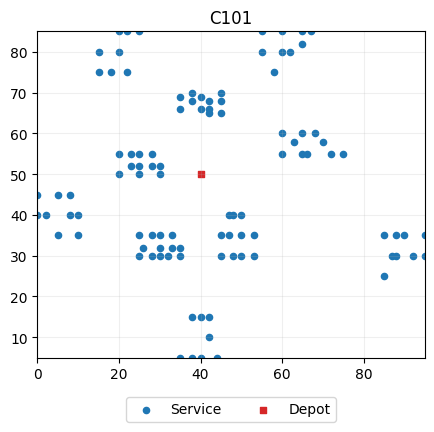

In [27]:
plot_instance_coords(instance_c101,
                     annotate=False,
                     point_size=20)

In [28]:
instance_c101.keys()

dict_keys(['name', 'num_agents', 'num_nodes', 'data', 'n_digits'])

In [29]:
instance_c101['name']

'C101'

In [30]:
instance_c101['num_agents']

25

In [31]:
instance_c101['num_nodes']

101

By customizing the arguments of the `.sample_instance` method, you can generate a **sub-instance** from the original environment instance. 

This allows for flexible scenario creation by selecting only a subset of nodes, which is particularly useful for testing, debugging, or curriculum learning setups.

In [32]:
instance = generator.sample_instance(num_agents=3, num_nodes=8)

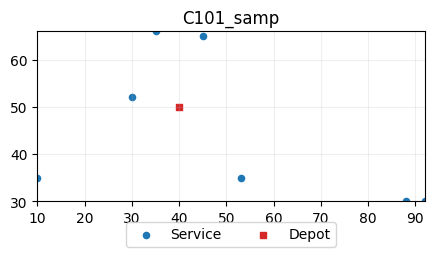

In [35]:
plot_instance_coords(instance,
                     annotate=False,
                     point_size=20)

In [33]:
instance['name']

'C101_samp'

In [34]:
instance['num_agents']

3

In [ ]:
instance['num_nodes']

 For the **CVRPTW** environment, setting `sample_type=None` will sample the first `n` service nodes from the instance. 

This approach follows the standard practice in Solomon benchmark datasets, where problem instances are defined by selecting the first `n` customers. For more details on this format, refer to the [Transportation Optimization Portal](https://www.sintef.no/projectweb/top/vrptw).


In [38]:
instance = generator.sample_instance(num_agents=3, num_nodes=8, sample_type=None)

In [39]:
instance['name']

'C101_samp'

###  Obervations

Observation features, which are made available to the active agent during its interaction with the environment, are handled by the `Observations` class. 

This class is responsible for defining what information the agent receives at each decision step, allowing for flexible customization of the observation space to suit different problem settings or learning strategies.

In [40]:
from maenvs4vrp.environments.cvrptw.observations import Observations

In [41]:
obs = Observations()

The class has a `default_feature_list` attribute where the default configuration dictionary is defined.

In [42]:
obs.default_feature_list

{'nodes_static': {'x_coordinate': {'feat': 'x_coordinate', 'norm': None},
  'y_coordinate': {'feat': 'y_coordinate', 'norm': None},
  'tw_low': {'feat': 'tw_low', 'norm': None},
  'tw_high': {'feat': 'tw_high', 'norm': None},
  'demand': {'feat': 'demand', 'norm': None},
  'service_time': {'feat': 'service_time', 'norm': 'min_max'},
  'is_depot': {'feat': 'is_depot', 'norm': None}},
 'nodes_dynamic': ['time2open_div_end_time',
  'time2close_div_end_time',
  'arrive2node_div_end_time',
  'time2open_after_step_div_end_time',
  'time2close_after_step_div_end_time',
  'time2end_after_step_div_end_time',
  'fract_time_after_step_div_end_time',
  'reachable_frac_agents'],
 'agent': ['x_coordinate',
  'y_coordinate',
  'frac_current_time',
  'frac_current_load',
  'arrivedepot_div_end_time',
  'frac_feasible_nodes'],
 'other_agents': ['x_coordinate',
  'y_coordinate',
  'frac_current_time',
  'frac_current_load',
  'frac_feasible_nodes',
  'dist2agent_div_end_time',
  'time_delta2agent_div_ma

Also, five possible features lists exist, detailing the available features in the class: `POSSIBLE_NODES_STATIC_FEATURES`, `POSSIBLE_NODES_DYNAMIC_FEATURES`, `POSSIBLE_SELF_FEATURES`, `POSSIBLE_AGENTS_FEATURES`, `POSSIBLE_GLOBAL_FEATURES`. For example:

In [43]:
obs.POSSIBLE_NODES_STATIC_FEATURES

['x_coordinate',
 'y_coordinate',
 'tw_low',
 'tw_high',
 'demand',
 'service_time',
 'tw_high_minus_tw_low_div_max_dur',
 'x_coordinate_min_max',
 'y_coordinate_min_max',
 'is_depot']

In [44]:
obs.POSSIBLE_GLOBAL_FEATURES

['frac_fleet_load_capacity', 'frac_done_agents']

While instantiating the `Observations` class, we can provide a dictionary specifying a list of features that will be made available to the agent. This feature list determines the content of the observation space, allowing us to customize what information the agent receives during training or evaluation.

In [45]:
import yaml

In [46]:
feature_list = yaml.safe_load("""
    nodes_static:
        x_coordinate_min_max:
            feat: x_coordinate_min_max
            norm: min_max
        x_coordinate_min_max: 
            feat: x_coordinate_min_max
            norm: min_max
        tw_low_mm:
            feat: tw_low
            norm: min_max
        tw_high:
            feat: tw_high
            norm: min_max

    nodes_dynamic:
        - time2open_div_end_time
        - time2close_div_end_time
        - time2open_after_step_div_end_time
        - time2close_after_step_div_end_time
        - fract_time_after_step_div_end_time

    agent:
        - x_coordinate_min_max
        - y_coordinate_min_max
        - frac_current_time
        - frac_current_load

    other_agents:
        - x_coordinate_min_max
        - y_coordinate_min_max
        - frac_current_time
        - frac_current_load
        - dist2agent_div_end_time
    
    global:
        - frac_demands
        - frac_fleet_load_capacity
        - frac_done_agents
        - frac_not_done_nodes
        - frac_used_agents
""")

In [47]:
obs = Observations(feature_list)

We can now test these observation settings directly within the environment:


In [48]:
gen = InstanceGenerator(batch_size = 8)
obs = Observations()
sel = AgentSelector()
rew = DenseReward()

env = Environment(instance_generator_object=gen,  
                  obs_builder_object=obs,
                  agent_selector_object=sel,
                  reward_evaluator=rew,
                  seed=0)

In [49]:
td = env.reset(batch_size = 8, num_agents=4, num_nodes=16)

In [50]:
td_observation = env.observe()

In [51]:
td_observation

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([8, 16]), device=cpu, dtype=torch.bool, is_shared=False),
        agent_obs: Tensor(shape=torch.Size([8, 6]), device=cpu, dtype=torch.float32, is_shared=False),
        agents_mask: Tensor(shape=torch.Size([8, 4]), device=cpu, dtype=torch.bool, is_shared=False),
        global_obs: Tensor(shape=torch.Size([8, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        node_dynamic_obs: Tensor(shape=torch.Size([8, 16, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        other_agents_obs: Tensor(shape=torch.Size([8, 4, 8]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([8]),
    device=cpu,
    is_shared=False)

###  Agent Iterator class

Equivalent to [PettingZoo](https://pettingzoo.farama.org/), Agent Selector class incorporates the iterator method `agent_iter` that returns the next active agent in the environment. It is perfectly customizable and currently  `AgentSelector`, `SmallestTimeAgentSelector` classes are available.

In [52]:
from maenvs4vrp.environments.cvrptw.env_agent_selector import AgentSelector, SmallestTimeAgentSelector

With `AgentSelector` class, the selection steps through the active agents in a circular fashion, until no more active agents are available:

In [53]:
gen = InstanceGenerator(batch_size = 1)
obs = Observations()
sel = AgentSelector()
rew = DenseReward()

env = Environment(instance_generator_object=gen,  
                  obs_builder_object=obs,
                  agent_selector_object=sel,
                  reward_evaluator=rew,
                  seed=0)

td = env.reset()

while not td["done"].all():  
    td = env.sample_action(td) # this is where we insert our policy
    td = env.step(td)
    step = env.env_nsteps
    cur_agent_idx = td['cur_agent_idx']
    print(f'env step number: {step}, active agent name: {cur_agent_idx}')

env step number: 1, active agent name: tensor([[0]])
env step number: 2, active agent name: tensor([[0]])
env step number: 3, active agent name: tensor([[1]])
env step number: 4, active agent name: tensor([[1]])
env step number: 5, active agent name: tensor([[1]])
env step number: 6, active agent name: tensor([[1]])
env step number: 7, active agent name: tensor([[2]])
env step number: 8, active agent name: tensor([[2]])
env step number: 9, active agent name: tensor([[2]])
env step number: 10, active agent name: tensor([[3]])
env step number: 11, active agent name: tensor([[3]])
env step number: 12, active agent name: tensor([[3]])
env step number: 13, active agent name: tensor([[3]])
env step number: 14, active agent name: tensor([[4]])
env step number: 15, active agent name: tensor([[4]])
env step number: 16, active agent name: tensor([[4]])
env step number: 17, active agent name: tensor([[4]])
env step number: 18, active agent name: tensor([[5]])
env step number: 19, active agent nam

With `SmallesttimeAgentSelector` class, the same agent is  select until it returns to the depot. Afterward, it selects the next active agent and repeats the process until all agents are done:

In [54]:
gen = InstanceGenerator(batch_size = 1)
obs = Observations()
sel = SmallestTimeAgentSelector()
rew = DenseReward()

env = Environment(instance_generator_object=gen,  
                  obs_builder_object=obs,
                  agent_selector_object=sel,
                  reward_evaluator=rew,
                  seed=0)

td = env.reset()

while not td["done"].all():  
    td = env.sample_action(td) # this is where we insert our policy
    td = env.step(td)
    step = env.env_nsteps
    cur_agent_idx = td['cur_agent_idx']
    print(f'env step number: {step}, active agent name: {cur_agent_idx}')

env step number: 1, active agent name: tensor([[1]])
env step number: 2, active agent name: tensor([[2]])
env step number: 3, active agent name: tensor([[3]])
env step number: 4, active agent name: tensor([[4]])
env step number: 5, active agent name: tensor([[5]])
env step number: 6, active agent name: tensor([[6]])
env step number: 7, active agent name: tensor([[7]])
env step number: 8, active agent name: tensor([[8]])
env step number: 9, active agent name: tensor([[9]])
env step number: 10, active agent name: tensor([[10]])
env step number: 11, active agent name: tensor([[11]])
env step number: 12, active agent name: tensor([[12]])
env step number: 13, active agent name: tensor([[13]])
env step number: 14, active agent name: tensor([[14]])
env step number: 15, active agent name: tensor([[15]])
env step number: 16, active agent name: tensor([[16]])
env step number: 17, active agent name: tensor([[17]])
env step number: 18, active agent name: tensor([[18]])
env step number: 19, active 

For a deeper dive into the library functionalities, explore the other available tutorials.

## Acknowledgements: 

* [PettingZoo](https://pettingzoo.farama.org/)

* [Flatland](https://flatland.aicrowd.com/intro.html)
